In [ ]:
#dwonload dataset dari roboflow
from roboflow import Roboflow
from pathlib import Path
API="JPiNvseFwcIDHZuT2vfx"; WS="leo-ueno"; PRJ="people-detection-o4rdr"; VER=1 #ws workslug kodenya ada di snippet roboflow, prj juga

rf = Roboflow(api_key=API)
project = rf.workspace(WS).project(PRJ)
version = project.version(VER)

outdir = f"/content/drive/MyDrive/Bootcampcv/humantracking/dataperson/roboflow/{PRJ}_v{VER}_yolov8"
Path(outdir).mkdir(parents=True, exist_ok=True)

ds = version.download("yolov8", location=outdir, overwrite=True)  # <- penting
print("Saved to:", ds.location)
!ls -lah "$outdir"


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/drive/MyDrive/Bootcampcv/humantracking/dataperson/roboflow/people-detection-o4rdr_v1_yolov8 in yolov8:: 100%|██████████| 2138/2138 [00:26<00:00, 80.05it/s]


Saved to: /content/drive/MyDrive/Bootcampcv/humantracking/dataperson/roboflow/people-detection-o4rdr_v1_yolov8
total 17K
-rw------- 1 root root  264 Nov  4 09:41 data.yaml
-rw------- 1 root root 2.1K Nov  4 09:41 README.dataset.txt
-rw------- 1 root root 1.4K Nov  4 09:41 README.roboflow.txt
drwx------ 4 root root 4.0K Nov  4 09:41 test
drwx------ 4 root root 4.0K Nov  4 09:41 train
drwx------ 4 root root 4.0K Nov  4 09:41 valid


In [ ]:
#cek apakah file zip benar benar ada
!ls -lh /content/drive/MyDrive/tugasbootcampcv/dataset_yolo/dataset_yolov9/data.yaml


-rw------- 1 root root 280 Nov  6 07:26 /content/drive/MyDrive/tugasbootcampcv/dataset_yolo/dataset_yolov9/data.yaml


In [ ]:
import torch, os, sys
!nvidia-smi -L || echo "⚠️ GPU belum aktif (Colab > Runtime > Change runtime type > GPU)"


/bin/bash: line 1: nvidia-smi: command not found
⚠️ GPU belum aktif (Colab > Runtime > Change runtime type > GPU)
Mounted at /content/drive


In [ ]:
from google.colab import drive; drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
#cek jumlah file, to make sure apa data sudah tercopy semua atau tidak
import os

base = "/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9"
for root, dirs, files in os.walk(base):
    print(root, "->", len(files), "files")


/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9 -> 3 files
/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/test -> 0 files
/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/test/images -> 768 files
/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/test/labels -> 768 files
/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train -> 1 files
/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/images -> 15552 files
/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/labels -> 15552 files
/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/valid -> 1 files
/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/valid/images -> 1472 files
/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_2025110

In [ ]:
# === All-in-one unzip + prepare YOLO dataset ===

from pathlib import Path
import zipfile, shutil, os, random, yaml, time

# ====== KONFIGURASI DASAR ======
ZIP_DIR   = Path("/content/drive/MyDrive/tugasbootcampcv")    # folder tempat ZIP berada
DEST_BASE = ZIP_DIR                                                            # parent untuk dataset hasil ekstrak
DATASET_NAME = "dataset_yolo"                                                  # nama folder output (bisa diganti)

# ====== 1) Pilih ZIP (ambil yang TERBESAR kalau ada beberapa) ======
zips = sorted(ZIP_DIR.glob("*.zip"))
if not zips:
    raise FileNotFoundError(f"Tidak ada file .zip di {ZIP_DIR}")

zip_path = max(zips, key=lambda p: p.stat().st_size)
print("ZIP terpilih:", zip_path.name, f"({zip_path.stat().st_size/1e6:.1f} MB)")

# ====== 2) Tentukan folder tujuan, buat yang unik jika sudah ada isinya ======
dest = DEST_BASE / DATASET_NAME
if dest.exists() and any(dest.iterdir()):
    ts = time.strftime("%Y%m%d_%H%M%S")
    dest = DEST_BASE / f"{DATASET_NAME}_{ts}"
dest.mkdir(parents=True, exist_ok=True)
print("Folder ekstrak:", dest)

# ====== 3) Ekstrak ZIP ======
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(dest)
print("Selesai ekstrak.")

# ====== 4) Cari ROOT dataset (handle kasus zip bersarang) ======
IMG_EXT = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}

def find_root_with_train_images(root: Path):
    # Cari path yang mengandung train/images
    for p in root.glob("**/train/images"):
        return p.parent.parent
    # fallback: root awal
    return root

ROOT = find_root_with_train_images(dest)
print("ROOT dataset:", ROOT.resolve())

# ====== 5) Normalisasi nama split: 'val' -> 'valid' ======
if (ROOT/"val").exists() and not (ROOT/"valid").exists():
    (ROOT/"val").rename(ROOT/"valid")
    print("Rename split: 'val' -> 'valid'")

# ====== 6) Buat 'valid' jika belum ada: ambil 10% dari train ======
def ensure_valid_split(root: Path, pct=0.10, seed=42):
    train_img = root/"train"/"images"
    train_lbl = root/"train"/"labels"
    valid_img = root/"valid"/"images"
    valid_lbl = root/"valid"/"labels"

    if valid_img.exists() and any(valid_img.iterdir()):
        print("Split 'valid' sudah ada.")
        return

    valid_img.mkdir(parents=True, exist_ok=True)
    valid_lbl.mkdir(parents=True, exist_ok=True)

    imgs = [p for p in train_img.glob("*") if p.suffix.lower() in IMG_EXT]
    if not imgs:
        print("⚠️ Tidak ada gambar di train/images. Lewati pembuatan valid.")
        return

    random.seed(seed)
    k = max(1, int(len(imgs)*pct))
    pick = set(random.sample(imgs, k))
    print(f"Membuat split 'valid' dari train: {k} file (~{int(pct*100)}%)")

    for img in pick:
        src_img = img
        src_lbl = train_lbl / f"{img.stem}.txt"
        dst_img = valid_img / img.name
        dst_lbl = valid_lbl / f"{img.stem}.txt"

        os.replace(src_img, dst_img)  # move cepat
        if src_lbl.exists():
            os.replace(src_lbl, dst_lbl)

ensure_valid_split(ROOT, pct=0.10)

# ====== 7) Hitung ringkasan per-split ======
def count_split(root: Path, sp: str):
    imgd = root/sp/"images"
    lbld = root/sp/"labels"
    n_img = sum(1 for p in imgd.glob("*") if p.suffix.lower() in IMG_EXT) if imgd.exists() else 0
    n_lbl = sum(1 for p in lbld.glob("*.txt")) if lbld.exists() else 0
    return n_img, n_lbl

for sp in ["train","valid","test"]:
    ni, nl = count_split(ROOT, sp)
    print(f"[{sp.upper():5}] images={ni} labels={nl}")

# ====== 8) Bangun / perbarui data.yaml ======
def infer_classes(root: Path):
    cls_ids = set()
    for sp in ["train","valid","test","val"]:
        for t in (root/sp/"labels").glob("*.txt"):
            for line in t.read_text().splitlines():
                s = line.strip()
                if not s: continue
                try:
                    cid = int(s.split()[0])
                    cls_ids.add(cid)
                except:
                    pass
    if not cls_ids:
        return 1, ["object"]
    nc = max(cls_ids) + 1
    names = [f"class_{i}" for i in range(nc)]
    return nc, names

train_path = (ROOT/"train"/"images").resolve()
val_path   = (ROOT/"valid"/"images").resolve() if (ROOT/"valid"/"images").exists() else train_path
test_path  = (ROOT/"test"/"images").resolve()  if (ROOT/"test"/"images").exists()  else None

nc, names = infer_classes(ROOT)
data_cfg = {
    "train": str(train_path),
    "val":   str(val_path),
    "nc":    nc,
    "names": names
}
if test_path:
    data_cfg["test"] = str(test_path)

DATA_YAML = ROOT/"data.yaml"
DATA_YAML.write_text(yaml.safe_dump(data_cfg, sort_keys=False))
print("\n== data.yaml ==")
print(DATA_YAML.read_text())
print("Lokasi data.yaml:", DATA_YAML)


ZIP terpilih: dataset_yolov9.zip (2115.0 MB)
Folder ekstrak: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557
Selesai ekstrak.
ROOT dataset: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9
Split 'valid' sudah ada.
[TRAIN] images=15552 labels=15552
[VALID] images=1472 labels=1472
[TEST ] images=768 labels=768

== data.yaml ==
train: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/images
val: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/valid/images
nc: 1
names:
- class_0
test: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/test/images

Lokasi data.yaml: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/data.yaml


In [ ]:
# ==== Training YOLO (Ultralytics) ====
!pip -q install -U ultralytics
from ultralytics import YOLO
from pathlib import Path

DATA_YAML = Path("/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/data.yaml")  # dari sel sebelumnya
RUN_NAME = "humantracking_yolov8n"



model = YOLO("yolov8n.pt")  # bisa ganti ke yolov8s.pt/m/l/x
results = model.train(
    data=str(DATA_YAML),
    epochs=50,
    imgsz=640,
    batch=16,
    optimizer='Adam',  #Optimizer AdamW untuk training yang lebih stabil
    device=0,
    cache=False,           # jangan "disk" agar Drive tidak cepat penuh
    workers=2,
    project='/content/drive/MyDrive/tugasbootcampcv/hasilprojecthumantracking',
    name=RUN_NAME,
    exist_ok=True,
    plots=True,                             # Menghasilkan grafik hasil training (loss, precision, recall, dll.)
    save=True,                              # Menyimpan hasil model setelah training
    save_period=1,       # Menyimpan checkpoint model setiap 1 epoch
    patience=15,
)


# Validasi & Test
best_w = Path(f"runs/detect/{RUN_NAME}/weights/best.pt")
eval_model = YOLO(str(best_w if best_w.exists() else "yolov8n.pt"))

print("\n== VALIDATION (split=val) ==")
eval_model.val(data=str(DATA_YAML), split="val", imgsz=640, device=0, plots=True)

print("\n== TEST (split=test) ==")
eval_model.val(data=str(DATA_YAML), split="test", imgsz=640, device=0, plots=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a8f4365c470>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
from ultralytics import YOLO  # import library YOLO dari ultralytics

# === SETUP ===

base_dir='/content/drive/MyDrive/tugasbootcampcv/hasilprojecthumantracking'
#base_dir = '/content/drive/MyDrive/Deteksi-Malaria1'  # path utama dataset dan hasil training di Google Drive
model_path = f'{base_dir}/humantracking_yolov8n/weights/best.pt'  # path model hasil training terbaik (best.pt)
DATA_YAML_PATH = '/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/data.yaml' # Corrected path to data.yaml

# Load model
model = YOLO(model_path)  # memuat model YOLOv8 dari file best.pt

# === EVALUASI TRAIN SET ===
metrics_train = model.val(data=DATA_YAML_PATH, split='train')  # evaluasi performa model pada data train

precision_train = metrics_train.box.p.mean()  # precision rata-rata semua kelas
recall_train = metrics_train.box.r.mean()  # recall rata-rata semua kelas
f1_score_train = metrics_train.box.f1.mean()  # f1-score rata-rata semua kelas
map50_train = metrics_train.box.map50.mean()  # mean average precision pada IoU=0.5
map_train = metrics_train.box.map.mean()  # mean average precision pada IoU=0.5:0.95

print("📊 Hasil evaluasi rata-rata TRAIN (semua kelas):")  # judul output evaluasi train
print(f"  - Precision     : {precision_train:.3f}")  # tampilkan precision dengan 3 desimal
print(f"  - Recall        : {recall_train:.3f}")  # tampilkan recall dengan 3 desimal
print(f"  - F1 Score      : {f1_score_train:.3f}")  # tampilkan F1-score dengan 3 desimal
print(f"  - mAP@0.5       : {map50_train:.3f}")  # tampilkan mAP pada IoU 0.5
print(f"  - mAP@0.5:0.95  : {map_train:.3f}\n")  # tampilkan mAP pada IoU 0.5–0.95

# === EVALUASI VAL SET ===
metrics_val = model.val(data=DATA_YAML_PATH, split='val')  # evaluasi performa model pada data val

precision_val = metrics_val.box.p.mean()  # precision rata-rata semua kelas
recall_val = metrics_val.box.r.mean()  # recall rata-rata semua kelas
f1_score_val = metrics_val.box.f1.mean()  # f1-score rata-rata semua kelas
map50_val = metrics_val.box.map50.mean()  # mean average precision pada IoU=0.5
map_val = metrics_val.box.map.mean()  # mean average precision pada IoU=0.5:0.95

print("📊 Hasil evaluasi rata-rata VAL (semua kelas):")  # judul output evaluasi val
print(f"  - Precision     : {precision_val:.3f}")  # tampilkan precision dengan 3 desimal
print(f"  - Recall        : {recall_val:.3f}")  # tampilkan recall dengan 3 desimal
print(f"  - F1 Score      : {f1_score_val:.3f}")  # tampilkan F1-score dengan 3 desimal
print(f"  - mAP@0.5       : {map50_val:.3f}")  # tampilkan mAP pada IoU 0.5
print(f"  - mAP@0.5:0.95  : {map_val:.3f}")  # tampilkan mAP pada IoU 0.5–0.95

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 45.8±31.6 MB/s, size: 99.2 KB)
val: Scanning /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/labels.cache... 15552 images, 1932 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 15552/15552 22.5Mit/s 0.0s
train: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/images/2007_000187_jpg.rf.6072bb3923494a7afb8648ba483324fd.jpg: 23 duplicate labels removed
train: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/images/2007_000999_jpg.rf.6c08f70e15d4b331a62dd733f71a31ef.jpg: 7 duplicate labels removed
train: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/images/2007_002260_jpg.rf.67b39e42171c963a3427b19a2abe68b4.jpg: 19 duplicate 

Using run : /content/drive/MyDrive/tugasbootcampcv/hasilprojecthumantracking/humantracking_yolov8n
Best pt   : /content/drive/MyDrive/tugasbootcampcv/hasilprojecthumantracking/humantracking_yolov8n/weights/best.pt
Data yaml : /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/data.yaml
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 28.1±12.8 MB/s, size: 35.4 KB)
val: Scanning /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/valid/labels.cache... 1472 images, 61 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1472/1472 2.1Mit/s 0.0s
val: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/valid/images/GX010023_frame_00025_right_jpg.rf.3255febc597d78d5d6e4bde455ba7b2a.jpg: 23 duplicate labels removed
WARNING ⚠️ Box and segment counts 

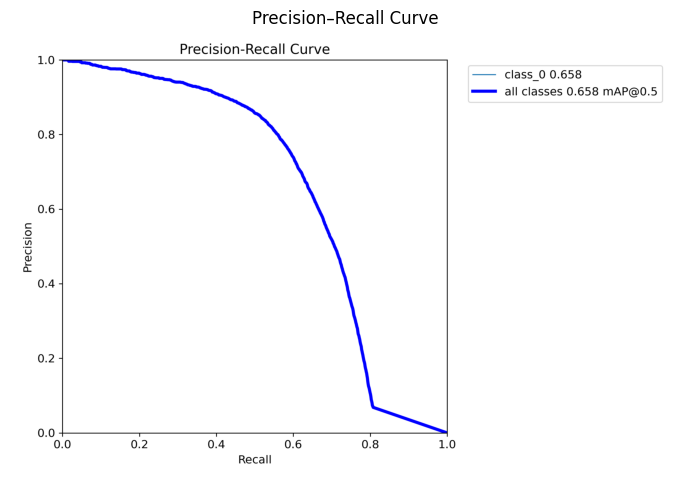

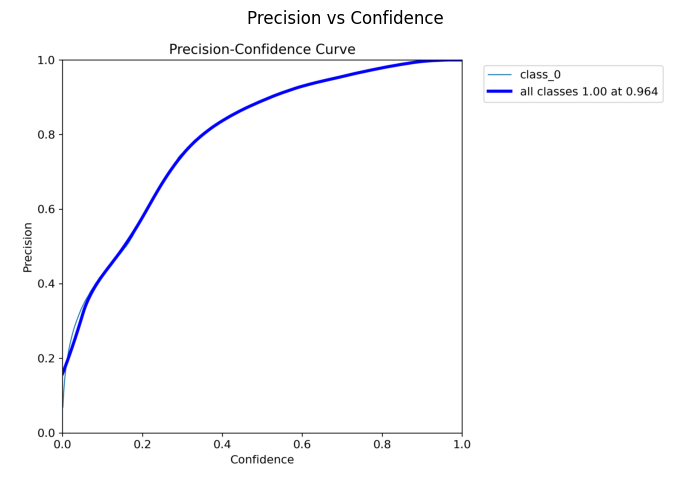

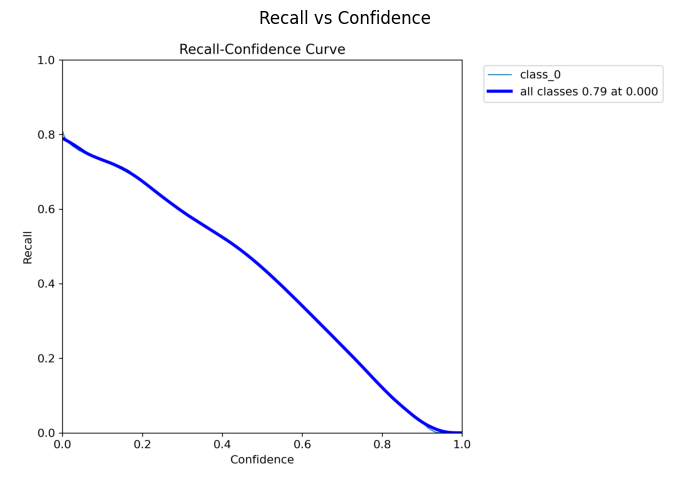

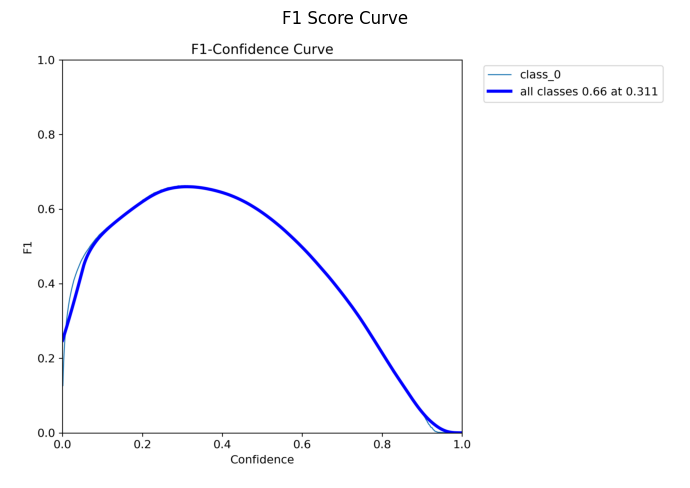

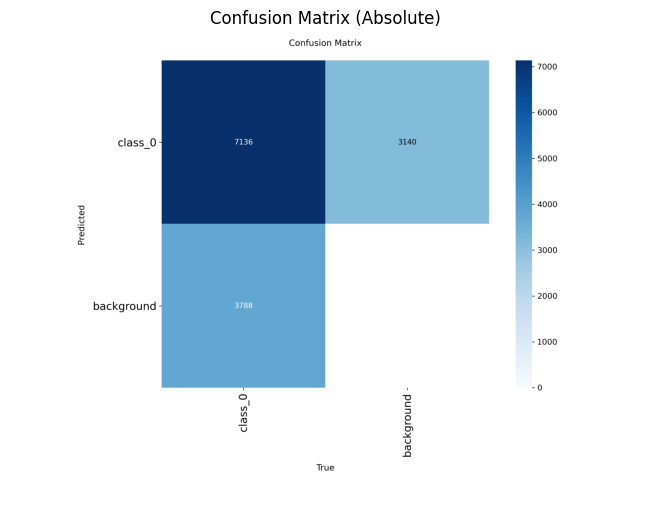

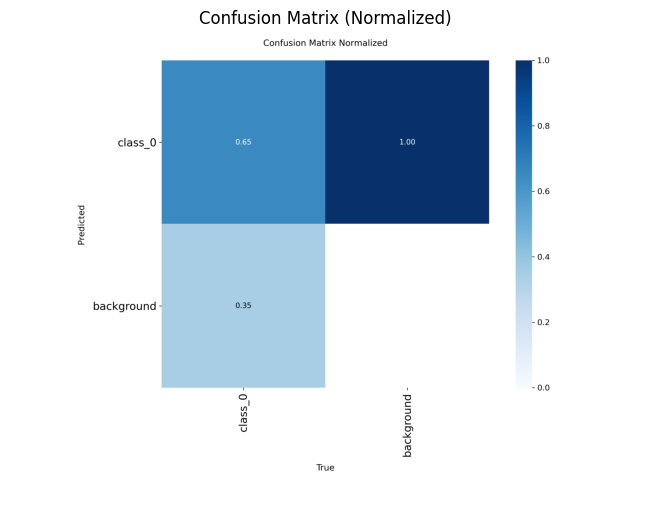


🖼️ Menampilkan 6 batch hasil validasi (label & prediksi):


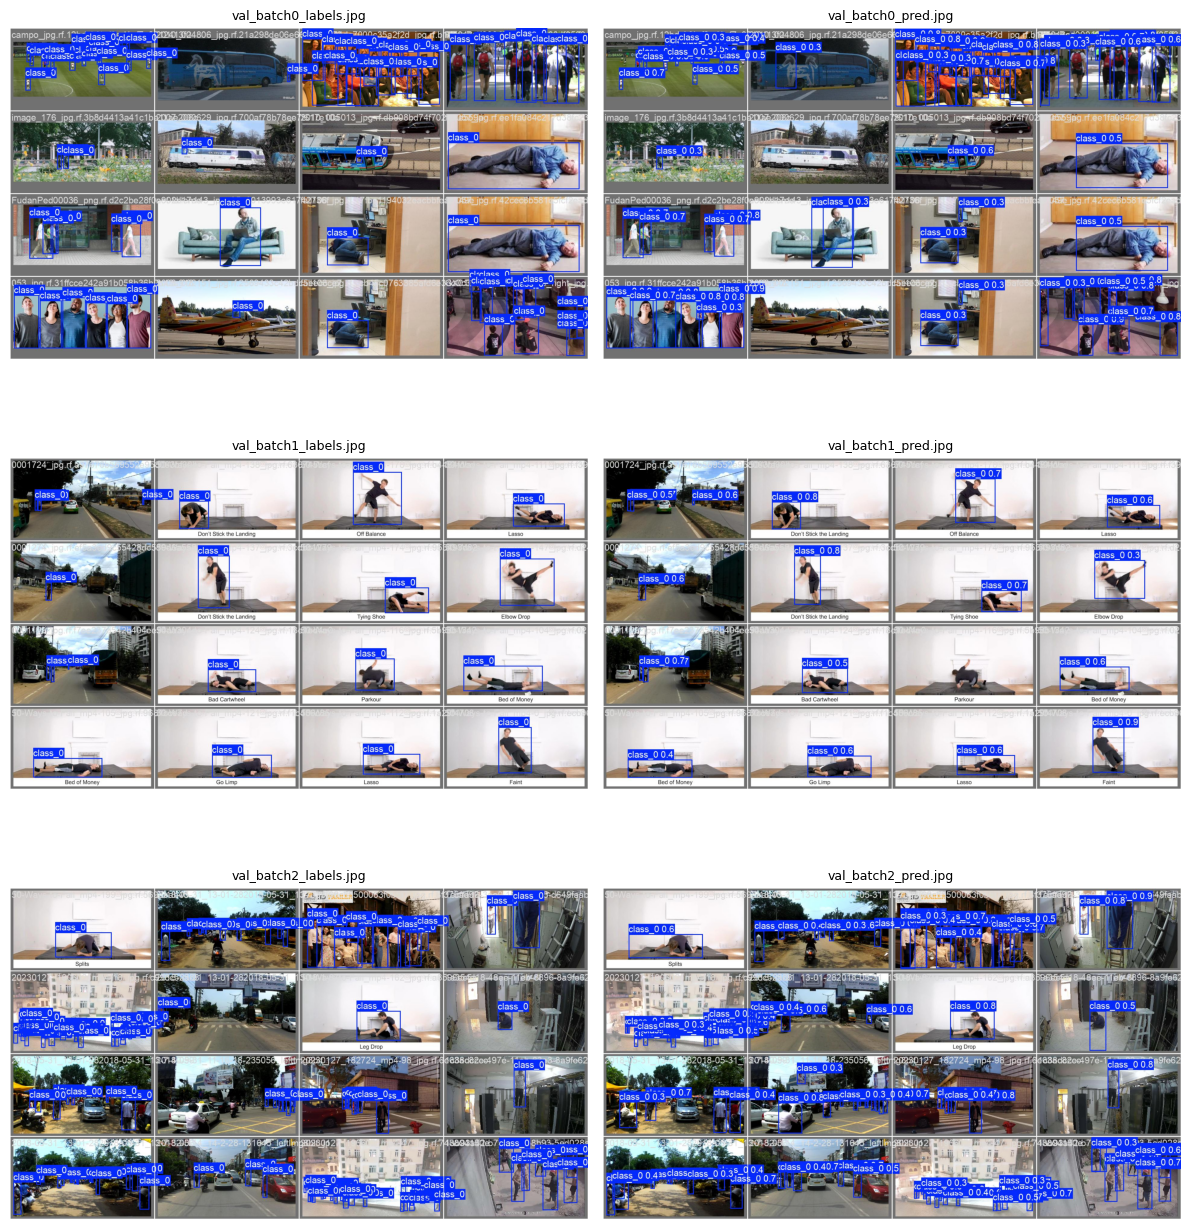


📘 Catatan:
- Precision tinggi -> sedikit false positive.
- Recall tinggi    -> sedikit miss (false negative).
- mAP50            -> akurasi deteksi pada IoU 0.5.
- mAP50-95         -> rata-rata mAP pada IoU 0.5..0.95 (lebih ketat).


In [ ]:
# =========================
# ✅ FINAL — Evaluation & Diagnostics (YOLOv8n)
# =========================
%matplotlib inline
from ultralytics import YOLO
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image

# --- Konfigurasi dasar ---
MODEL_TAG = "yolov8n"  # <<< ganti ke 'yolov8m' / 'yolov8l' kalau mau
# Use the project and name from the training cell (XfUhN0Fluiog)
RUN_ROOT  = Path('/content/drive/MyDrive/tugasbootcampcv/hasilprojecthumantracking')
RUN_NAME = f"humantracking_{MODEL_TAG}"
DATA_YAML = Path("/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/data.yaml").as_posix() # Use the path from cell TgJcnS3emnOk


# Find the latest run directory with the specified name
runs = sorted(
    (p for p in RUN_ROOT.glob(f"{RUN_NAME}")),
    key=os.path.getmtime
)

assert runs, f"Tidak menemukan run dengan nama {RUN_NAME} di {RUN_ROOT}"
ACTIVE_RUN = runs[-1]
BEST_PT    = ACTIVE_RUN / "weights" / "best.pt"


print("Using run :", ACTIVE_RUN.as_posix())
print("Best pt   :", BEST_PT.as_posix())
print("Data yaml :", DATA_YAML)

# --- 1️⃣ Validasi model (generate metrik + kurva + batch val) ---
model = YOLO(BEST_PT.as_posix())
metrics = model.val(
    data=DATA_YAML,
    split="val",
    imgsz=640,
    iou=0.50,
    conf=0.001,     # biarkan rendah agar PR/F1 curve komplit
    save_json=False,
    verbose=False,
    plots=True      # penting agar YOLO menyimpan kurva & val_batch*.jpg
)

# --- 2️⃣ Tampilkan hasil metrik utama ---
print("\n== Summary Metrics ==")
rd = metrics.results_dict
for k in ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]:
    print(f"{k:>24s}: {rd.get(k):.4f}")

# --- 3️⃣ Cari folder runs/detect/val terbaru (hasil val resmi dari barusan) ---
# The validation results are saved within the ACTIVE_RUN directory
VAL_DIR = ACTIVE_RUN # The validation results are saved in the ACTIVE_RUN directory

assert VAL_DIR.exists(), "Validation results directory does not exist."
print(f"\n📁 Folder hasil evaluasi resmi: {VAL_DIR}")


# --- 4️⃣ Helper untuk menampilkan gambar ---
def show_img(path, title=None, size=6):
    path = Path(path)
    if not path.exists():
        print(f"⚠️ {path.name} tidak ditemukan")
        return
    img = Image.open(path)
    plt.figure(figsize=(size, size * 0.75))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# --- 5️⃣ Tampilkan grafik metrik (Precision, Recall, F1, Confusion Matrix) ---
print("\n📊 Menampilkan plot hasil evaluasi:")
candidates = [
    ("BoxPR_curve.png", "Precision–Recall Curve"),
    ("BoxP_curve.png",  "Precision vs Confidence"),
    ("BoxR_curve.png",  "Recall vs Confidence"),
    ("BoxF1_curve.png", "F1 Score Curve"),
    ("confusion_matrix.png", "Confusion Matrix (Absolute)"),
    ("confusion_matrix_normalized.png", "Confusion Matrix (Normalized)"),
]
for fname, title in candidates:
    show_img(VAL_DIR / fname, title, size=7)

# --- 6️⃣ Tampilkan batch validasi (label & prediksi) dari folder val ---
val_imgs = sorted(VAL_DIR.glob("val_batch*.jpg"))
if val_imgs:
    print(f"\n🖼️ Menampilkan {len(val_imgs)} batch hasil validasi (label & prediksi):")
    cols = 2
    rows = (len(val_imgs) + cols - 1) // cols
    plt.figure(figsize=(cols * 6, rows * 4.5))
    for i, p in enumerate(val_imgs, start=1):
        img = Image.open(p)
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(p.name, fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Tidak ditemukan file val_batch*.jpg di folder val.")

# --- 7️⃣ Catatan bacaan metrik ---
print("\n📘 Catatan:")
print("- Precision tinggi -> sedikit false positive.")
print("- Recall tinggi    -> sedikit miss (false negative).")
print("- mAP50            -> akurasi deteksi pada IoU 0.5.")
print("- mAP50-95         -> rata-rata mAP pada IoU 0.5..0.95 (lebih ketat).")

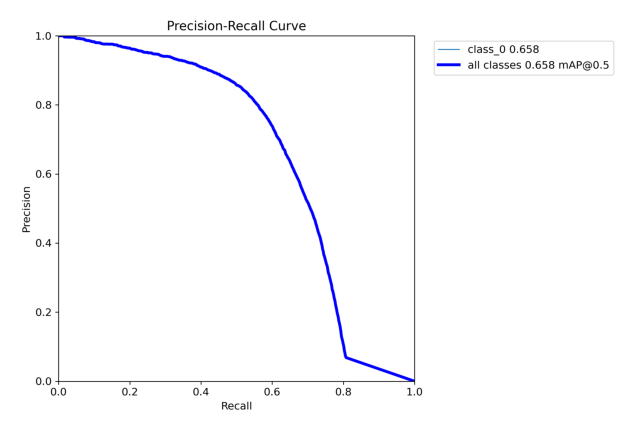

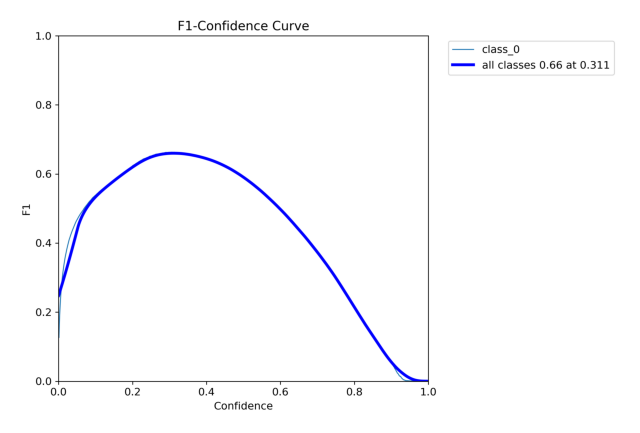

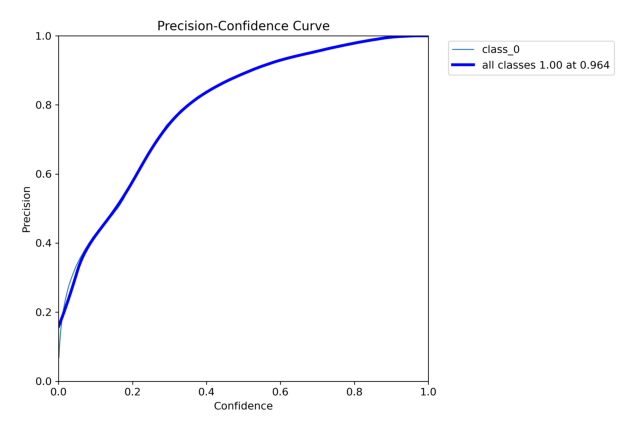

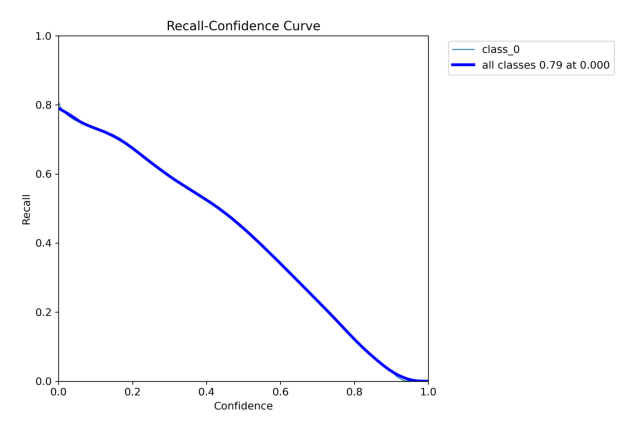

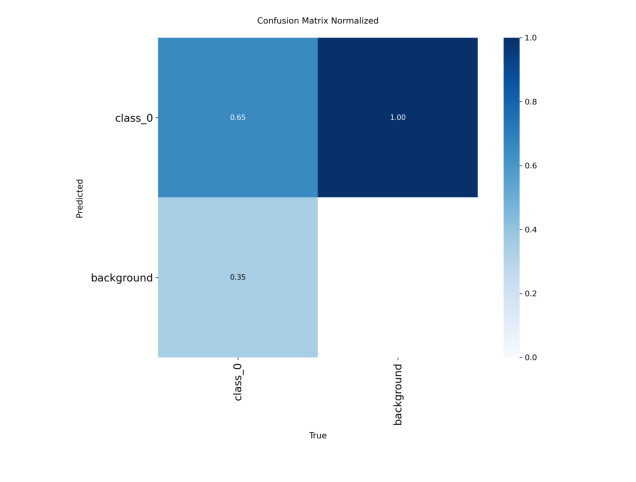

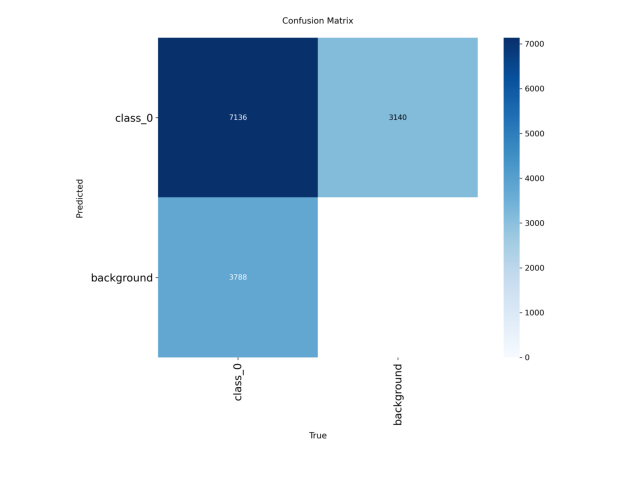

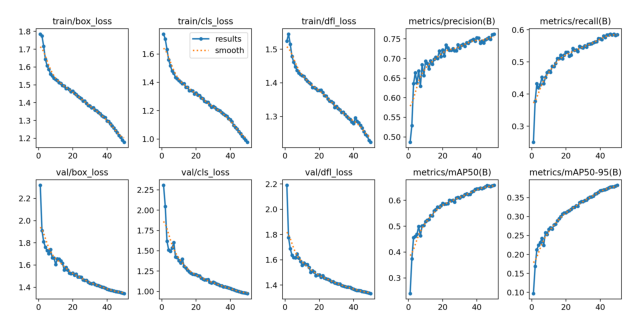

In [ ]:
import matplotlib.pyplot as plt
import os

# Path ke folder hasil training
project_dir = '/content/drive/MyDrive/tugasbootcampcv/hasilprojecthumantracking/humantracking_yolov8n'

# List file .png hasil grafik yang dihasilkan oleh YOLOv8 (loss, precision, recall, dll.)
plot_files = [f for f in os.listdir(project_dir) if f.endswith('.png')]

# Menampilkan grafik yang dihasilkan
for plot in plot_files:
    plot_path = os.path.join(project_dir, plot)
    img = plt.imread(plot_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')  # Matikan axis untuk menampilkan gambar bersih
    plt.show()


In [ ]:
from ultralytics import YOLO  # import library YOLO dari ultralytics

# === SETUP ===
base_dir = '/content/drive/MyDrive/tugasbootcampcv/hasilprojecthumantracking'
model_path = f'{base_dir}/humantracking_yolov8n/weights/best.pt'  # path model hasil training terbaik (best.pt)
DATA_YAML_PATH = '/content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/data.yaml'  # path dataset.yaml

# Load model
model = YOLO(model_path)  # memuat model YOLOv8 dari file best.pt

# === EVALUASI TRAIN SET ===
metrics_train = model.val(data=DATA_YAML_PATH, split='train')  # evaluasi performa model pada data train

# Extracting metrics from the evaluation results
precision_train = metrics_train.box.p.mean()  # precision rata-rata semua kelas
recall_train = metrics_train.box.r.mean()  # recall rata-rata semua kelas
f1_score_train = metrics_train.box.f1.mean()  # f1-score rata-rata semua kelas
map50_train = metrics_train.box.map50.mean()  # mean average precision pada IoU=0.5
map_train = metrics_train.box.map.mean()  # mean average precision pada IoU=0.5:0.95

# Print evaluation results for the training set
print("📊 Hasil evaluasi rata-rata TRAIN (semua kelas):")
print(f"  - Precision     : {precision_train:.3f}")
print(f"  - Recall        : {recall_train:.3f}")
print(f"  - F1 Score      : {f1_score_train:.3f}")
print(f"  - mAP@0.5       : {map50_train:.3f}")
print(f"  - mAP@0.5:0.95  : {map_train:.3f}")

# === EVALUASI VAL SET ===
metrics_val = model.val(data=DATA_YAML_PATH, split='val')  # evaluasi performa model pada data val

# Extracting metrics from the validation results
precision_val = metrics_val.box.p.mean()  # precision rata-rata semua kelas
recall_val = metrics_val.box.r.mean()  # recall rata-rata semua kelas
f1_score_val = metrics_val.box.f1.mean()  # f1-score rata-rata semua kelas
map50_val = metrics_val.box.map50.mean()  # mean average precision pada IoU=0.5
map_val = metrics_val.box.map.mean()  # mean average precision pada IoU=0.5:0.95

# Print evaluation results for the validation set
print("\n📊 Hasil evaluasi rata-rata VAL (semua kelas):")
print(f"  - Precision     : {precision_val:.3f}")
print(f"  - Recall        : {recall_val:.3f}")
print(f"  - F1 Score      : {f1_score_val:.3f}")
print(f"  - mAP@0.5       : {map50_val:.3f}")
print(f"  - mAP@0.5:0.95  : {map_val:.3f}")

# === Evaluasi tambahan dan diagnostik ===
# Model diagnostics
# print("\n📊 Model Diagnostics (Train/Val Comparison):")
# print(f"  - Total Epochs     : {len(metrics_train.epochs)}")  # Removed: DetMetrics object has no attribute 'epochs'
# print(f"  - Train Loss       : {metrics_train.losses[-1]:.4f}")  # Removed: DetMetrics object has no attribute 'losses'
# print(f"  - Validation Loss : {metrics_val.losses[-1]:.4f}")  # Removed: DetMetrics object has no attribute 'losses'
# print(f"  - Best mAP@0.5    : {max(metrics_val.box.map50):.3f}")  # Removed: DetMetrics object has no attribute 'map50' (it's a single value)

# Plotting confusion matrix and other diagnostics (optional)
# (If metrics contain confusion matrix data or additional diagnostic data)
# metrics_train.plot_confusion_matrix()  # Confusion matrix untuk train set
# metrics_val.plot_confusion_matrix()  # Confusion matrix untuk val set

# Displaying results in other formats like ROC, Precision-Recall Curve, etc.
# metrics_train.plot_precision_recall()  # Plot precision-recall curve untuk train set
# metrics_val.plot_precision_recall()  # Plot precision-recall curve untuk val set

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 51.8±52.7 MB/s, size: 95.1 KB)
val: Scanning /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/labels.cache... 15552 images, 1932 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 15552/15552 21.0Mit/s 0.0s
train: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/images/2007_000187_jpg.rf.6072bb3923494a7afb8648ba483324fd.jpg: 23 duplicate labels removed
train: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/images/2007_000999_jpg.rf.6c08f70e15d4b331a62dd733f71a31ef.jpg: 7 duplicate labels removed
train: /content/drive/MyDrive/tugasbootcampcv/dataset_yolo_20251106_083557/dataset_yolov9/train/images/2007_002260_jpg.rf.67b39e42171c963a3427b19a2abe68b4.jpg: 19 duplicate 

In [ ]:
Z

In [ ]:
#unzip file dan dimasukkan ke folder datasettambahan
#jadinya data sy download langsung ke lokal lalu diupload ke folder datasettambahan
!unzip -o /content/drive/MyDrive/Bootcampcv/projecthumantracking/datasetpeopledetection.zip -d /content/drive/MyDrive/Bootcampcv/projecthumantracking/dataset3


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/drive/MyDrive/Bootcampcv/projecthumantracking/dataset3/train/labels/FudanPed00035_png.rf.2928a6dadaed81ebaaefd8d8c1b1fbc3.txt  
  inflating: /content/drive/MyDrive/Bootcampcv/projecthumantracking/dataset3/train/labels/FudanPed00035_png.rf.c89ff584ea8483398444e4e7d3428bc8.txt  
  inflating: /content/drive/MyDrive/Bootcampcv/projecthumantracking/dataset3/train/labels/FudanPed00037_png.rf.54bd7c5b9fca6c12097e674e8d9e2300.txt  
  inflating: /content/drive/MyDrive/Bootcampcv/projecthumantracking/dataset3/train/labels/FudanPed00037_png.rf.9f91e445dac1f141005faae99a6c627e.txt  
  inflating: /content/drive/MyDrive/Bootcampcv/projecthumantracking/dataset3/train/labels/FudanPed00037_png.rf.f7e2006f1b05d5d9f9cdfe6e1c067201.txt  
  inflating: /content/drive/MyDrive/Bootcampcv/projecthumantracking/dataset3/train/labels/FudanPed00038_png.rf.0904400c761d87b0980e9265770f4658.txt  
  inflating: /content/drive/MyDrive/Bootc